In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import scipy
import sklearn
import os
from scipy.signal import butter, filtfilt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [ ]:

data_folder = r"D:\dataset eeg"


npz_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]
eeg_data = {}
for file in npz_files:
    file_path = os.path.join(data_folder, file)
    data = np.load(file_path, allow_pickle=True)
    eeg_data[file] = data


first_file = npz_files[0]
print(f"Keys in {first_file}: {list(eeg_data[first_file].keys())}")


Keys in eeg-predictive_train.npz: ['train_signals', 'train_labels']


In [ ]:

train_signals_1 = eeg_data["eeg-predictive_train.npz"]["train_signals"]
train_labels_1 = eeg_data["eeg-predictive_train.npz"]["train_labels"]

train_signals_2 = eeg_data["eeg-seizure_train.npz"]["train_signals"]
train_labels_2 = eeg_data["eeg-seizure_train.npz"]["train_labels"]


train_signals = np.concatenate((train_signals_1, train_signals_2), axis=0)
train_labels = np.concatenate((train_labels_1, train_labels_2), axis=0)


print("Merged Train Signals Shape:", train_signals.shape)
print("Merged Train Labels Shape:", train_labels.shape)


Merged Train Signals Shape: (45948, 23, 256)
Merged Train Labels Shape: (45948,)


In [ ]:

seizure_indices = np.where(train_labels == 1)[0]
non_seizure_indices = np.where(train_labels == 0)[0]


np.random.seed(42)  
seizure_sample = np.random.choice(seizure_indices, 5000, replace=False)
non_seizure_sample = np.random.choice(non_seizure_indices, 5000, replace=False)


selected_indices = np.concatenate((seizure_sample, non_seizure_sample))


train_signals_balanced = train_signals[selected_indices]
train_labels_balanced = train_labels[selected_indices]


print("Balanced Train Signals Shape:", train_signals_balanced.shape)
print("Balanced Train Labels Shape:", train_labels_balanced.shape)


unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("New Label Distribution:", dict(zip(unique, counts)))

Balanced Train Signals Shape: (10000, 23, 256)
Balanced Train Labels Shape: (10000,)
New Label Distribution: {0.0: 5000, 1.0: 5000}


In [ ]:

mav = np.mean(np.abs(train_signals_balanced), axis=(1,2))


severe_threshold = np.percentile(mav, 90)  
mild_threshold = np.percentile(mav, 50)    


new_labels = []
for value in mav:
    if value >= severe_threshold:
        new_labels.append(1)
    elif value >= mild_threshold:
        new_labels.append(2)  
    else:
        new_labels.append(0)  

train_labels_balanced = np.array(new_labels)


unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("Updated Label Distribution:", dict(zip(unique, counts)))



Updated Label Distribution: {0: 5000, 1: 1000, 2: 4000}


In [ ]:

train_signals_balanced = (train_signals_balanced - np.min(train_signals_balanced)) / (np.max(train_signals_balanced) - np.min(train_signals_balanced))

print("EEG Signals After Normalization:")
print("Min:", np.min(train_signals_balanced), "Max:", np.max(train_signals_balanced))

EEG Signals After Normalization:
Min: 0.0 Max: 1.0


In [ ]:

def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)


train_signals_filtered = bandpass_filter(train_signals_balanced)

print("EEG Signals After Bandpass Filtering:")
print("Shape:", train_signals_filtered.shape)

EEG Signals After Bandpass Filtering:
Shape: (10000, 23, 256)


In [ ]:
from tensorflow.keras.utils import to_categorical


train_labels_onehot = to_categorical(train_labels_balanced, num_classes=3)


print("Example of One-Hot Encoded Labels:")
print(train_labels_onehot[:5])

Example of One-Hot Encoded Labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
#fe-lstm mt-lstm+Autoencoder
def extract_lstm_features(data, n_features=64):
    model = Sequential([
        Input(shape=(data.shape[1], data.shape[2])),
        LSTM(n_features, return_sequences=False),
        Dropout(0.2),
        Dense(n_features, activation='relu')
    ])
    features = model.predict(data)
    return features, model

n_features = 64
train_features, feature_extractor = extract_lstm_features(train_signals_filtered, n_features)
print("Extracted Features Shape:", train_features.shape)



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Extracted Features Shape: (10000, 64)


In [ ]:


def create_hybrid_model(input_shape, n_classes=3):
    # Encoder
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    encoded = Dropout(0.2)(x)

    
    latent = Dense(32, activation='relu')(encoded)
     
    class_output = Dense(n_classes, activation='softmax', name='classification')(latent)

    # Decoder Branch
    x = Dense(64)(latent)
    x = RepeatVector(input_shape[0])(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(128, return_sequences=True)(x)
    decoded = TimeDistributed(Dense(input_shape[1]), name='time_distributed')(x)

    # Define Hybrid Model
    model = Model(inputs=inputs, outputs=[decoded, class_output])

    
    model.compile(optimizer='adam',
                  loss={'classification': 'categorical_crossentropy', 'time_distributed': 'mse'},
                  loss_weights={'classification': 1.0, 'time_distributed': 0.5},
                  metrics={'classification': 'accuracy'})

    return model


X = train_signals_filtered
y = train_labels_onehot

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model = create_hybrid_model(input_shape=(X.shape[1], X.shape[2]))

batch_size = 64
epochs = 20


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classification_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)


history = model.fit(
    X_train,
    {'classification': y_train, 'time_distributed': X_train},
    validation_data=(X_val, {'classification': y_val, 'time_distributed': X_val}),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - classification_accuracy: 0.4844 - classification_loss: 0.9586 - loss: 0.9589 - time_distributed_loss: 4.2192e-04 - val_classification_accuracy: 0.8025 - val_classification_loss: 0.4920 - val_loss: 0.4905 - val_time_distributed_loss: 3.9170e-04
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - classification_accuracy: 0.8028 - classification_loss: 0.4768 - loss: 0.4770 - time_distributed_loss: 3.6796e-04 - val_classification_accuracy: 0.8730 - val_classification_loss: 0.3179 - val_loss: 0.3202 - val_time_distributed_loss: 3.8321e-04
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - classification_accuracy: 0.8643 - classification_loss: 0.3460 - loss: 0.3462 - time_distributed_loss: 3.5316e-04 - val_classification_accuracy: 0.8805 - val_classification_loss: 0.2852 - val_loss: 0.2865 - val_time_distributed_loss: 3.8327e-04
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - classification_accuracy: 0.8899 - classificatio

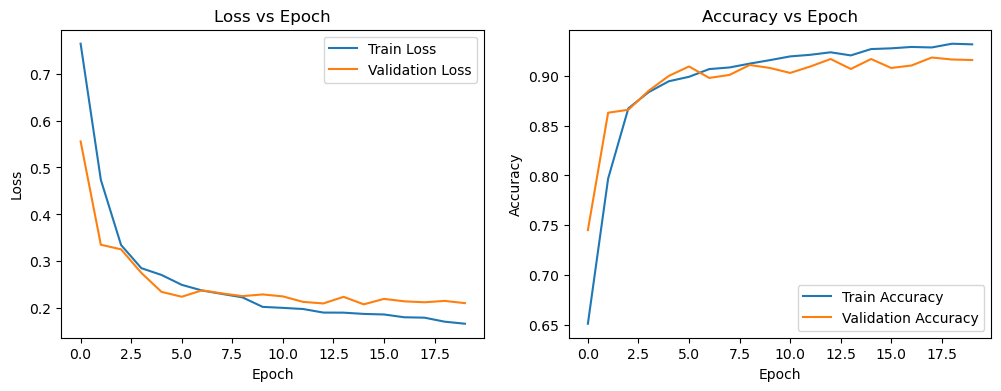

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1000
           1       0.90      0.94      0.92       200
           2       0.91      0.87      0.89       800

    accuracy                           0.91      2000
   macro avg       0.91      0.92      0.91      2000
weighted avg       0.91      0.91      0.91      2000



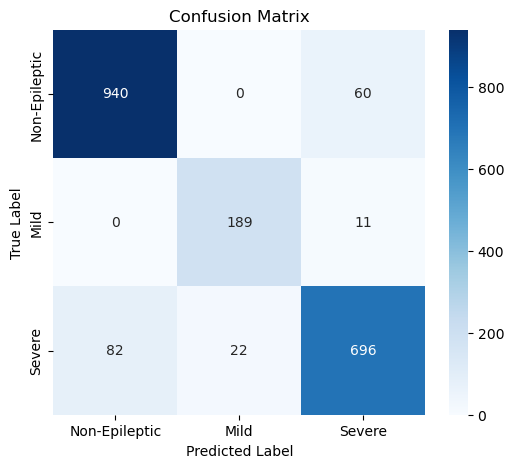

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


y_pred = model.predict(X_val)[1] 
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true_classes = np.argmax(y_val, axis=1)  


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Epileptic', 'Mild', 'Severe'], yticklabels=['Non-Epileptic', 'Mild', 'Severe'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


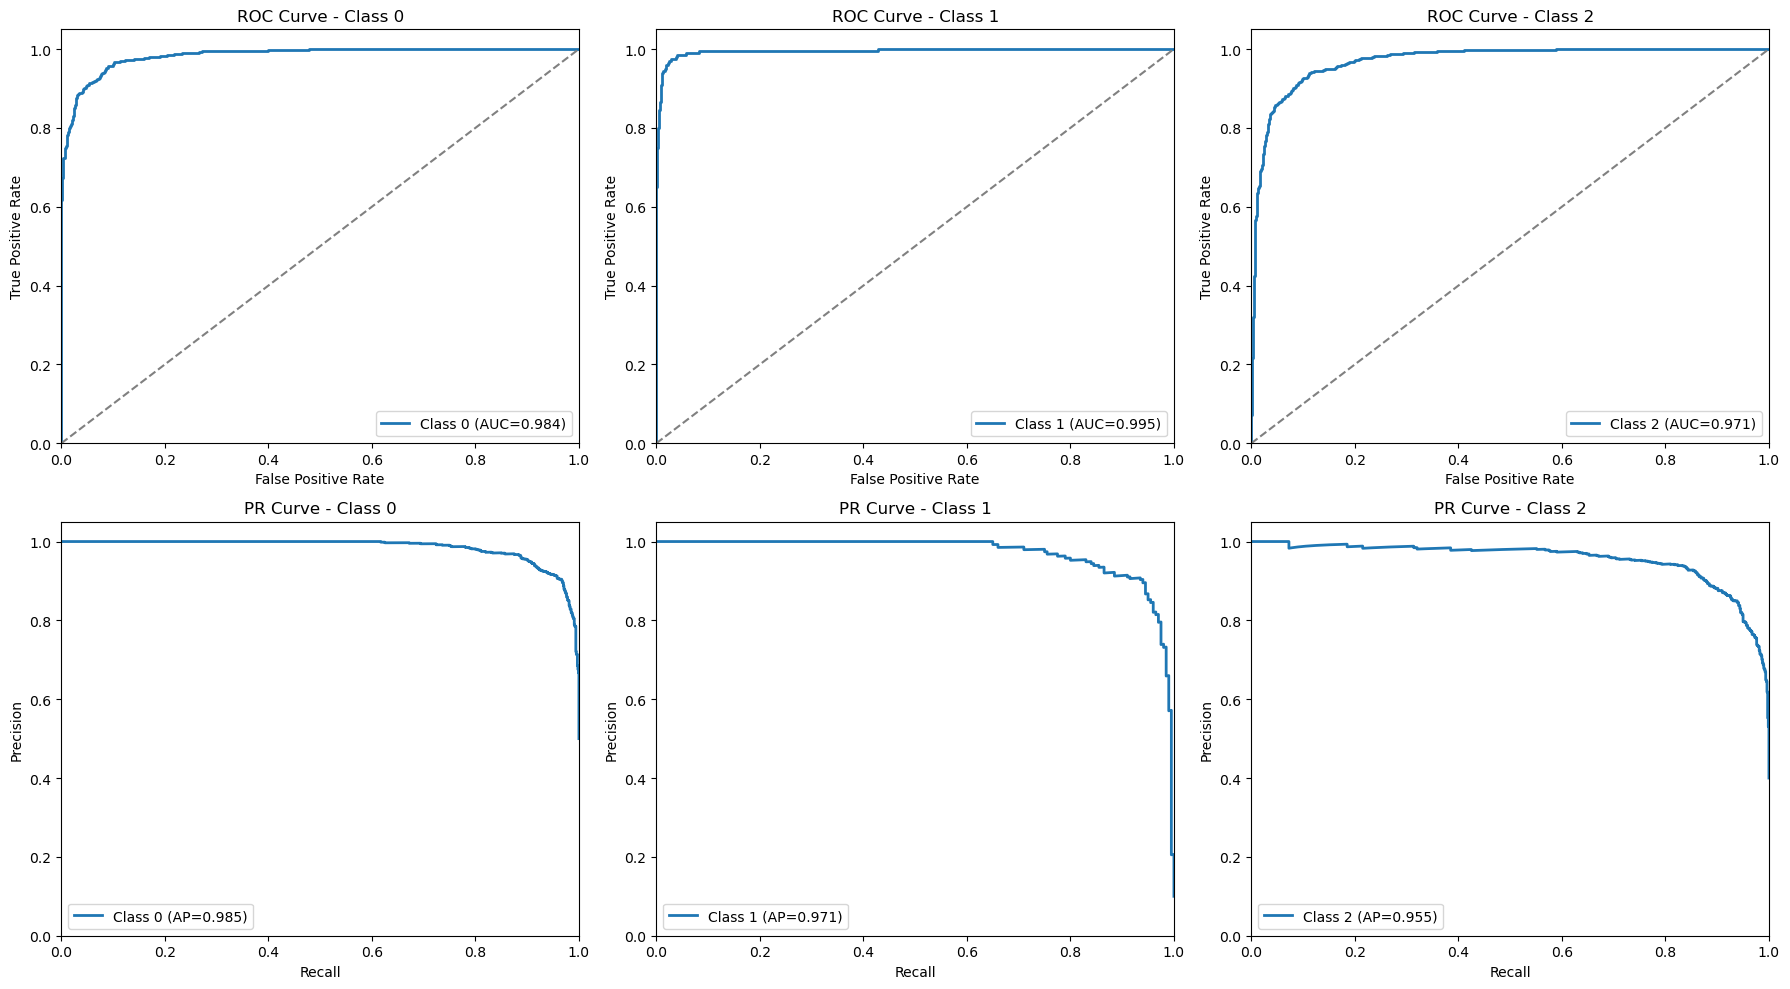

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


n_classes = y_true.shape[1]

fig, axes = plt.subplots(2, n_classes, figsize=(18, 10))


roc_auc_scores = []
ap_scores = []

for i in range(n_classes):

    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

    
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true[:, i], y_pred_probs[:, i])
    ap_scores.append(ap)

    
    axes[0, i].plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc:.3f})')
    axes[0, i].plot([0, 1], [0, 1], color="gray", linestyle="--") 
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - Class {i}')
    axes[0, i].legend(loc="lower right")

    
    axes[1, i].plot(recall, precision, lw=2, label=f'Class {i} (AP={ap:.3f})')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall')
    axes[1, i].set_ylabel('Precision')
    axes[1, i].set_title(f'PR Curve - Class {i}')
    axes[1, i].legend(loc="lower left")


plt.tight_layout()
plt.show()


Feature Extraction Step - Input Shape for Model: (10000, 256, 23)


Model: "functional_21"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 256, 23)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_feature_extra… │ (None, 256, 32)   │      7,168 │ input_sequence[0… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 256, 32)   │          0 │ lstm_feature_ext… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        12

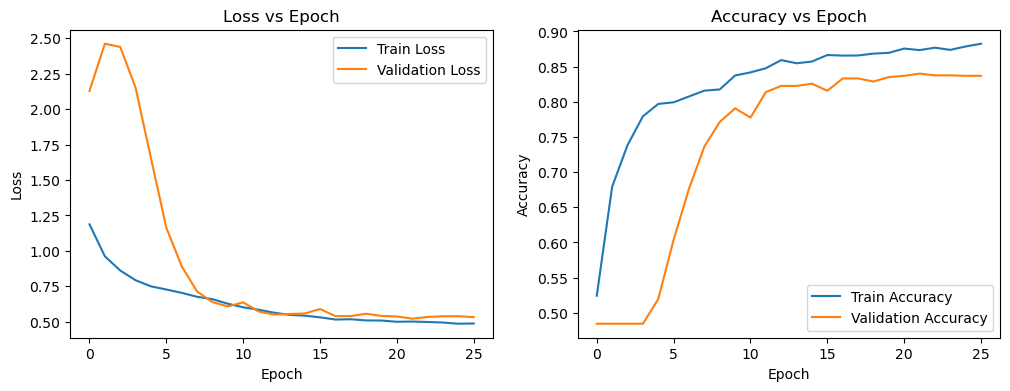

In [ ]:
#2 fe-lstm mt-transformer

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling1D, Dropout, LayerNormalization, Add, MultiHeadAttention, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns





X = np.transpose(train_signals_filtered, (0, 2, 1))  
print("Feature Extraction Step - Input Shape for Model:", X.shape)


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.5):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x_ff = Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1], kernel_regularizer=tf.keras.regularizers.l2(0.002))(x_ff)
    
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    return x


input_seq = Input(shape=(256, 23), name="input_sequence")


x = LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.002), name="lstm_feature_extractor")(input_seq)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)  

x = transformer_encoder(x, head_size=32, num_heads=2, ff_dim=32, dropout=0.5)


x = GlobalAveragePooling1D(name="global_avg_pool")(x)


x = Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002), name="dense_classifier")(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax', name="classification_output")(x)

model = Model(inputs=input_seq, outputs=output)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary(model)

X_train, X_test, y_train, y_test = train_test_split(
    X, train_labels_onehot, test_size=0.2, random_state=42, stratify=train_labels_balanced
)

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop, reduce_lr]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')

plt.show()


In [ ]:
#1 fe-inceptionV3  mt- lstm+autoencoder

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import re

X = train_signals_filtered 
X_expanded = np.expand_dims(X, axis=-1)         
X_tiled = np.tile(X_expanded, (1, 1, 1, 3))     
X_resized = tf.image.resize(X_tiled, (75, 75)).numpy()  
X_preprocessed = preprocess_input(X_resized)


inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
features = inception_model.predict(X_preprocessed)
print("Extracted features shape:", features.shape)  


num_samples, h, w, c = features.shape
sequence_features = features.reshape((num_samples, h, w * c))
print("Sequence features shape:", sequence_features.shape) 

seq_length = h
feature_dim = w * c


input_seq = Input(shape=(seq_length, feature_dim), name="input_sequence")


encoded = LSTM(256, return_sequences=False, name="encoder_lstm1")(input_seq)
encoded = Dense(128, activation='relu', name="encoder_dense")(encoded)
encoded = Dropout(0.3, name="encoder_dropout")(encoded)


repeated = RepeatVector(seq_length, name="repeat_vector")(encoded)
decoded = LSTM(128, return_sequences=True, name="decoder_lstm")(repeated)
decoder_output = TimeDistributed(Dense(feature_dim), name="decoder_output")(decoded)


classifier_dense = Dense(64, activation='relu', name="classifier_dense")(encoded)
classifier_dense = Dropout(0.3, name="classifier_dropout")(classifier_dense)
classification_output = Dense(3, activation='softmax', name="classification_output")(classifier_dense)


hybrid_model = Model(inputs=input_seq, outputs=[decoder_output, classification_output])


hybrid_model.compile(
    optimizer='adam', 
    loss={
        'decoder_output': 'mse', 
        'classification_output': 'categorical_crossentropy'
    },
    loss_weights={
        'decoder_output': 0.5,            
        'classification_output': 1.0     
    },
    metrics={
        'classification_output': 'accuracy'
    }
)

model.summary(hybrid_model)

X_train, X_test, y_train_class, y_test_class = train_test_split(
    sequence_features,
    train_labels_onehot,
    test_size=0.2,
    random_state=42,
    stratify=train_labels_balanced
)


early_stopping = EarlyStopping(monitor='val_classification_output_accuracy', patience=5, restore_best_weights=True,mode='max')


history = hybrid_model.fit(
    X_train, 
    {'decoder_output': X_train, 'classification_output': y_train_class},
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)


results = hybrid_model.evaluate(
    X_test, 
    {'decoder_output': X_test, 'classification_output': y_test_class}
)
print("Test results:", results)


_, class_preds = hybrid_model.predict(X_test)
y_pred_classes = np.argmax(class_preds, axis=1)
y_true_classes = np.argmax(y_test_class, axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step
Extracted features shape: (10000, 1, 1, 2048)
Sequence features shape: (10000, 1, 2048)


Model: "functional_23"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 1, 2048)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm1       │ (None, 256)       │  2,360,320 │ input_sequence[0… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense       │ (None, 128)       │     32,896 │ encoder_lstm1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout     │ (None, 128)       │          

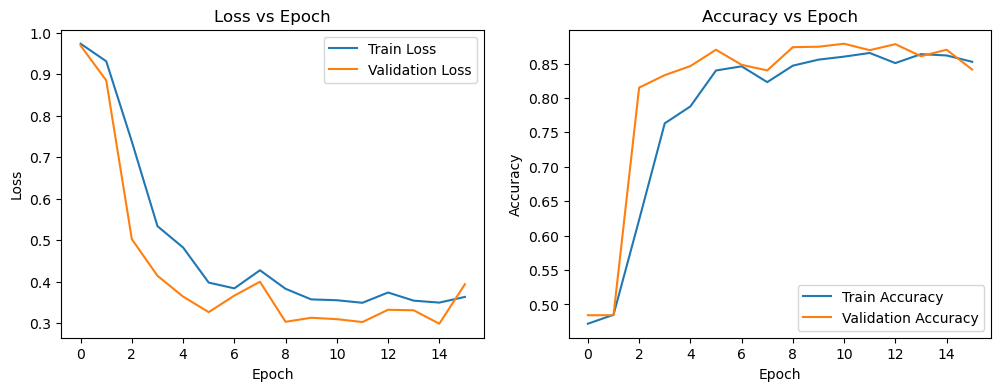

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['classification_output_loss'], label='Train Loss')
plt.plot(history.history['val_classification_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')

plt.show()



In [ ]:
from sklearn.metrics import classification_report, f1_score


report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2'])


print("Classification Report:\n", report)


f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_micro = f1_score(y_true_classes, y_pred_classes, average='micro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')




Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.89      0.91      1000
     Class 1       0.77      0.83      0.80       200
     Class 2       0.83      0.86      0.84       800

    accuracy                           0.87      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.88      0.87      0.87      2000



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


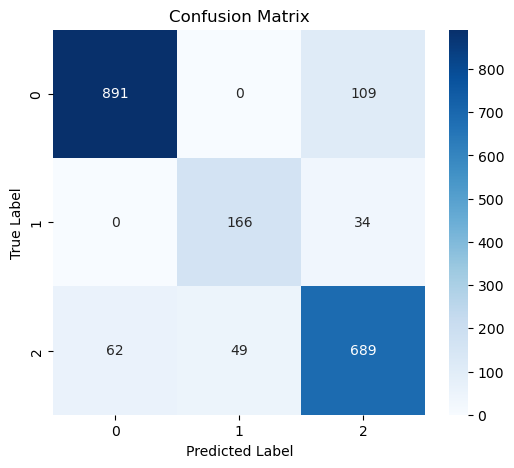

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


_, class_preds = hybrid_model.predict(X_test)
y_pred_classes = np.argmax(class_preds, axis=1)
y_true_classes = np.argmax(y_test_class, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


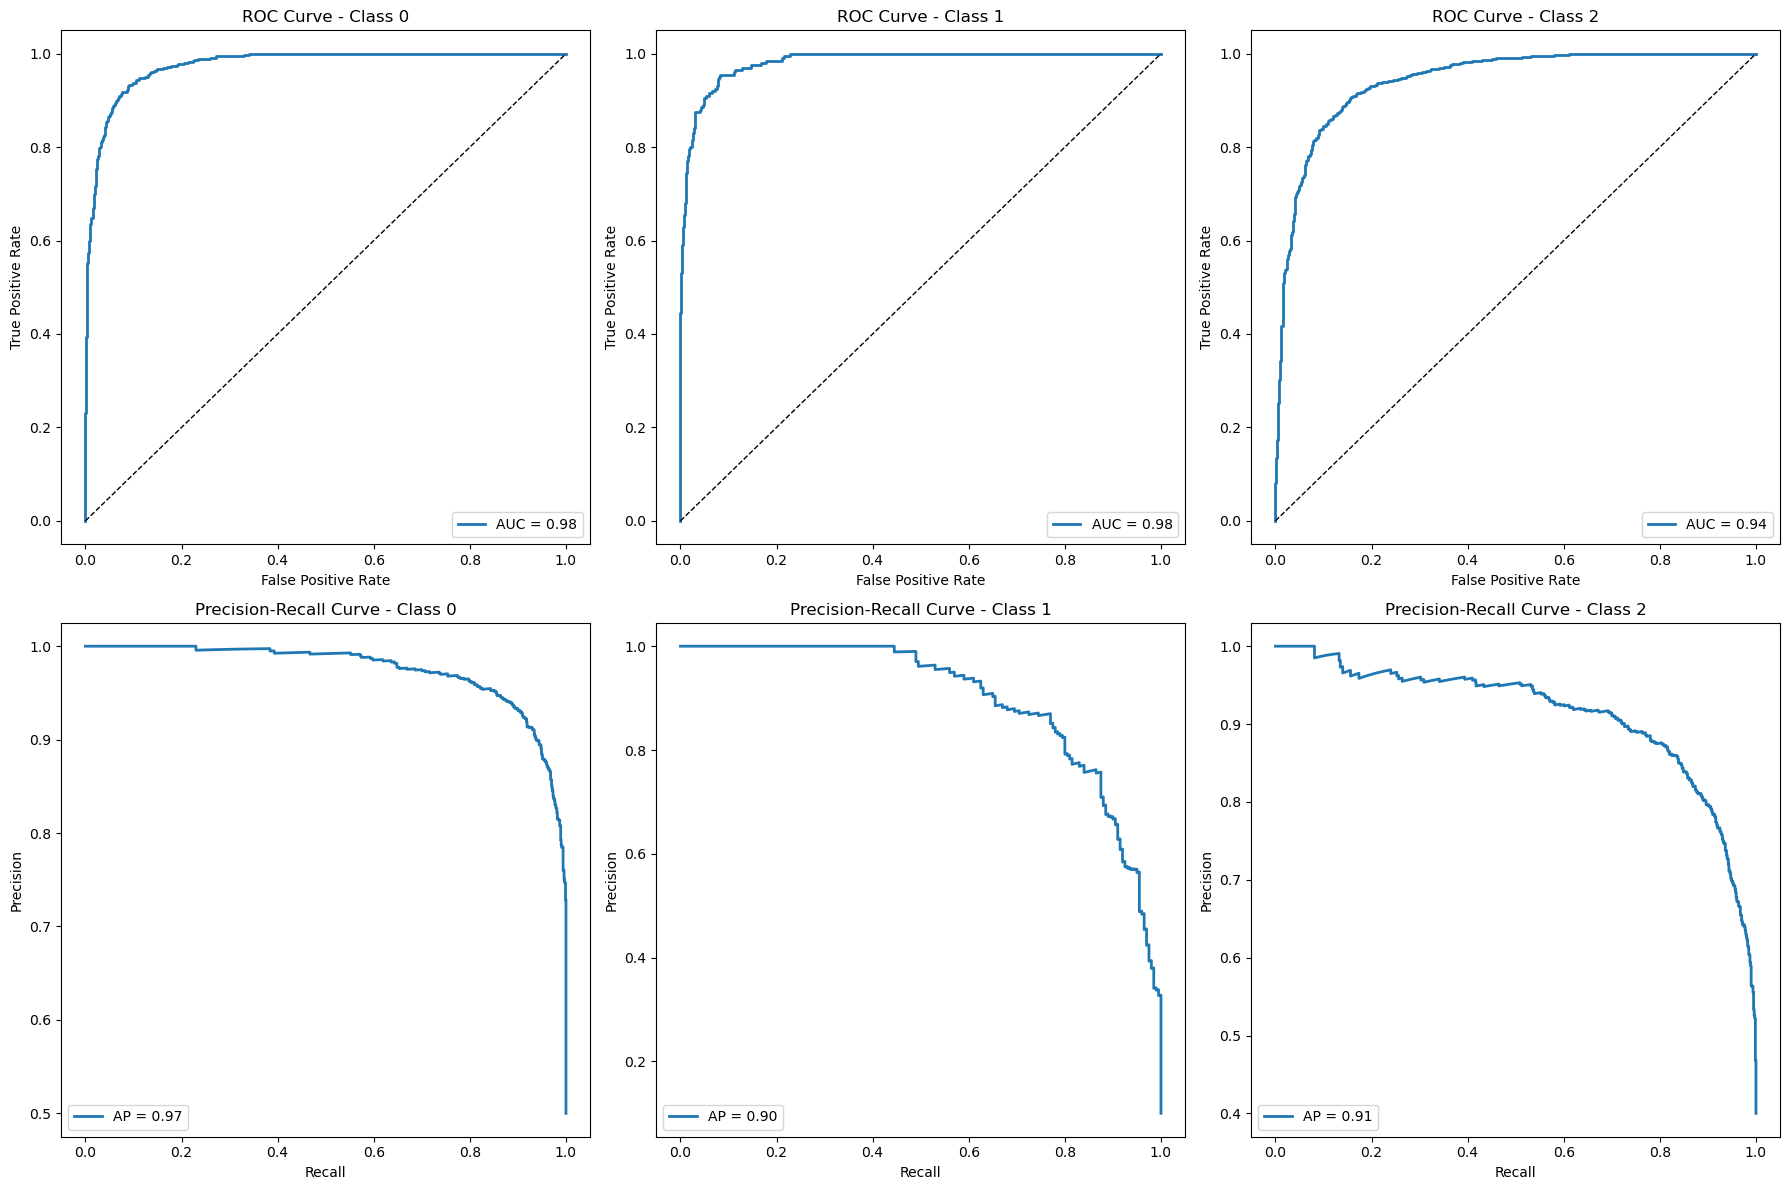

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(3):  
    
    fpr, tpr, _ = roc_curve(y_test_class[:, i], class_preds[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[0, i].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', linewidth=2)
    axes[0, i].plot([0, 1], [0, 1], 'k--', linewidth=1)  
    axes[0, i].set_xlabel("False Positive Rate")
    axes[0, i].set_ylabel("True Positive Rate")
    axes[0, i].set_title(f"ROC Curve - Class {i}")
    axes[0, i].legend(loc="lower right")
    
    precision, recall, _ = precision_recall_curve(y_test_class[:, i], class_preds[:, i])
    ap_score = average_precision_score(y_test_class[:, i], class_preds[:, i])  
    
    axes[1, i].plot(recall, precision, label=f'AP = {ap_score:.2f}', linewidth=2)
    axes[1, i].set_xlabel("Recall")
    axes[1, i].set_ylabel("Precision")
    axes[1, i].set_title(f"Precision-Recall Curve - Class {i}")
    axes[1, i].legend(loc="lower left")

plt.tight_layout()
plt.show()
